In [1]:
%load_ext autoreload
%autoreload 2

import simplenn as sn
import numpy as np

from simplenn import utils


# Capa de Entropía Cruzada

En este ejercicio debés implementar la capa de error `CrossEntropyWithLabels`, que permite calcular el error de un modelo que emite probabilidades en términos de distancias entre distribuciones. 

En este caso, el `WithLabels` indica que la distribución de probabilidad verdadera (obtenida del conjunto de datos) en realidad se codifica con etiquetas. de modo que para un problema de `C=3` clases, si un ejemplo es de clase 2 (contando desde 0), entonces su etiqueta es `2`. Esta es una manera cómoda de especificar que su codificación como distribución de probabilidad sería `[0,0,1]`, es decir, un vector de `3` elementos, donde el elemento `2` (de nuevo, contando desde 0), tiene probabilidad 1 y el resto 0.



# Método forward


El método `forward` de la capa `CrossEntropyWithLabels` asume que su entrada `y` es una distribución de probabilidades, es decir, `C` valores positivos que suman 1, donde `C` es la cantidad de clases. Asimismo, `y_true` es una etiqueta que indica cual clase de las `C` es la correcta.

Por ejemplo, si $y=(0.3,0.4,0.3)$ y $y_{true}=2$ entonces habrá un error considerable, ya que el valor $y_{true}=2$ indicaba que se esperaba la distribución  $y=(0,0,1)$. Entonces, los valores $0.3$ y $0.4$ de las clases 0 y 1 deberían bajar, y el valor $0.3$ de la clase 2 debería subir

La entropía cruzada cuantifica este error calculando el negativo del logaritmo de la probabilidad de la clase 
correcta ($-ln(y_{y_{true}})$), en este caso, de la clase 2 ($-ln(y_2)$). Entonces, 

$$EntropíaCruzada(y,y_true)=EntropíaCruzada((0.3,0.4,0.3),2)=-ln(0.3)=1.20$$

Reiteramos, en este caso se eligió el valor $0.3$ porque es el que está en el índice 2 del vector $y$, es decir, otra forma de escribir lo anterior sería:

$$E(y,y_{true})=-ln(y_{y_{true}})=-ln(0.3)=1.20$$

La razón por la cual se utiliza la función $-ln(0.3)$ para penalizar es que si para la clase correcta la probabilidad es 1, entonces $-ln(y_{y_{true}})=-ln(1)=-0=0$, y entonces no hay penalización. Caso contrario, la salida de $-ln$ será positiva e indicará un error. De esta forma se logra penalizar que la probabilidad de la clase correcta no llegue a 1. Podemos visualizar esto fácilmente en un gráfico de la función $-ln(x)$:

<img src="cross_entropy.png" width="400">

Por último, como los valores de $y$ están normalizados, no es necesario penalizar que el resto de las probabilidades sea mayor a 0; si el error lleva a que la probabilidad de la clase correcta a ser 1, entonces el resto va a tener que ser 0. Por este motivo (y otros), la entropía cruzada es una buena combinación con la función softmax para entrenar modelos de clasificación.

En el caso de un lote de ejemplos, el cálculo es independiente para cada ejemplo.

Implementá el método `forward` de la clase `CrossEntropyWithLabels`:


In [2]:
y = np.array([[1,0],
             [0.5,0.5],
              [0.5,0.5],
             ])
y_true = np.array([0,0,1])


layer=sn.CrossEntropyWithLabels()
E=-np.log(np.array([[1],[0.5],[0.5]]))

utils.check_same(E,layer.forward(y_true,y))

SUCCESS :) Arrays are equal (tolerance 1e-12)


# Método backward

Dado que el método `backward` de la entropía cruzada es un poco larga, te dejamos [este apunte](http://facundoq.github.io/guides/crossentropy_derivative) con la derivación de todos los casos. 

Nuevamente, como este error es por cada ejemplo, entonces los cálculos son independientes en cada fila.

Implementá el método `backward` de la clase `CrossEntropyWithLabels`:

In [3]:
# number of random values of x and δEδy to generate and test gradients
samples = 100
batch_size=2
features_in=3
features_out=5
input_shape=(batch_size,features_in)


layer=sn.CrossEntropyWithLabels()
utils.check_gradient.cross_entropy_labels(layer,input_shape,samples=samples,tolerance=1e-5)    


CrossEntropyWithLabels_1 layer:
 ERROR 
δEδy
 Relative error (max):0.00005 (tolerance: 1e-05)
######################## Details: ######################## 
 Input y:
[[0.00060303 0.57274397 0.426653  ]
 [0.40373896 0.1114152  0.48484584]]
 Input δEδy:
[[1.]
 [1.]]
 δEδy (numerical, automatic):
[[-1658.43559356     0.             0.        ]
 [    0.            -8.97543613     0.        ]]
 δEδy (analytic, your implementation):
[[-1658.28356444     0.             0.        ]
 [    0.            -8.97543611     0.        ]]
##########################################################



# Regresión Logística aplicada a la clasificación de Flores

Ahora que tenemos todos los elementos, podemos definir y entrenar nuestro primer modelo regresión logística para clasificar las flores del conjunto de datos de [Iris](https://www.kaggle.com/uciml/iris).

En este caso, vamos a entrenar el modelo con la función de error cuadrático medio; no obstante, si bien esta función de error funcionará, hace el que problema de optimización no sea _convexo_ y por ende no haya un único mínimo global. Más adelante, implementaremos la función de error de _Entropía Cruzada_, diseñada específicamente para lidiar con salidas que representan distribuciones de probabilidad.

Tamaños de x e y: (150, 4) (150,)


fit:   0%|          | 0/1000 [00:00<?, ?it/s]

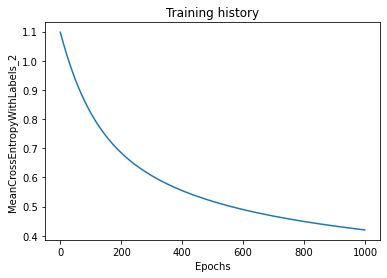

Métricas del modelo:
Accuracy: 0.8533333333333334 (3 classes)
Confusion matrix: (rows true, columns pred)
[[50  0  0]
 [ 0 41  9]
 [ 0 13 37]]


In [4]:

# Cargar datos con las salidas como etiquetas
# (nota: las etiquetas de clase comienzan en 0)
x,y,classes=sn.datasets.load_classification("iris")
# normalización de los datos
x = (x-x.mean(axis=0))/x.std(axis=0)
n, din = x.shape
# calcular cantidad de clases
classes = y.max()+1
print("Tamaños de x e y:", x.shape,y.shape)

#Modelo de regresión logística, 
# tiene `din` dimensiones de entrada (4 para iris)
# y `classes` de salida `3 para iris`
model = sn.LogisticRegression(din,classes)
# Error cuadrático medio
error = sn.MeanError(sn.CrossEntropyWithLabels())
optimizer = sn.StochasticGradientDescent(lr=0.001,epochs=1000,batch_size=32)

# Algoritmo de optimización
history = optimizer.optimize(model,x,y,error)
sn.plot.plot_history(history,error_name=error.name)


print("Métricas del modelo:")
y_pred=model.forward(x)
y_pred_labels=utils.onehot2labels(y_pred)
sn.metrics.classification_summary(y,y_pred_labels)
#sn.plot.regression1d_predictions(y,y_pred_labels)